# Segmentation using Images.jl
Image Segmentation is the process of partitioning the image into regions that have similar attributes. Image segmentation has various applications e.g, medical image segmentation, image compression and is used as a preprocessing step in higher level vision tasks like object detection and optical flow.

The algorithms we'll explore today have the following properties:

- every pixel in the image is assigned to a "segment"
- segments are disjoint: a pixel belongs to exactly one segment

Images has some algorithms (e.g., `fuzzy_cmeans`) that don't fit these properties, but they're not on the agenda for today.

There is no agreed-upon definition of "similar attributes"---different algorithms make different choices and use different criteria. It's not clear that there's a genuine "ground truth" against which one can compare different algorithms; one may use the choices of human observers, but even two different observers may come to different conclusions.

## Introductory example: unseeded region growing

Let's see an example for segmenting vegetables image. We will be using unseeded region growing for segmentation example below.

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\timho\OneDrive\Documents\Presentations\2023JuliaConImages\JuliaCon23_ImageProcessingWorkshop`


In [2]:
using Images, TestImages

Images.jl provides segmentation algorithms through ImageSegmentation.jl. We load `peppers_color` from TestImages.jl and resize it to (256,256):

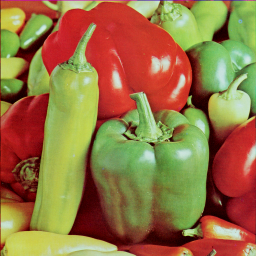

In [3]:
img = testimage("peppers_color")
img = imresize(img, (256,256))

Let's apply `unseeded_region_growing` to parition different portions of the image. This algorithm requires a "difference threshold" specifying when a pixel is too different from an adjacent region to be added to it. Generally, you have to tune the threshold for your specific image to get results that you find plausible.

In [4]:
seg = unseeded_region_growing(img, #= difference threshold =# 0.3)

Segmented Image with:
  labels map: 256×256 Matrix{Int64}
  number of labels: 16

This algorithm, like the others we'll explore today, returns a `SegmentedImage` from which one can extract several items of interest:

In [5]:
labels_map(seg)

256×256 Matrix{Int64}:
  1   2   2  2  2   2  13  13  13  13  …  14  11  11  11  11  13  13  13  13
  1   2   2  2  2   2   2   2   2   2      1   1   1   1   1   1   1   1   1
  1   2   2  2  2   2   2   2   2   2      1   1   1   1   1   1   1   1   1
  1   2   2  2  2   2   2   2   2   2      1   1   1   1   1   1   1   1   1
  1   2   2  2  2   2   2   2   2   2      1   1   1   1   1   1   1   1   1
  1   2   2  2  2   2   2   2   2   2  …   1   1   1   1   1   1   1   1   1
  1   2   2  2  2   2   2   2   2   2      1   1   1   1   1   1   1   1   1
  1   1   2  2  2   2   2   2   2   2      1   1   1   1   1   1   1   1   1
  1   1   2  2  2   2   2   2   2   2      1   1   1   1   1   1   1   1   1
  1   1   4  4  4   4   4   4   4   4      1   1   1   1   1   1   1   1   1
  1   4   4  4  4   4   4   4   4   4  …   1   1   1   1   1   1   1   1   1
  1   4   4  4  4   4   4   4   4   4      1   1   1   1   1   1   1   1   1
  1   4   4  4  4   4   4   4   4   4      1   1   1 

`labels_map` returns an array which is same size as original image and each pixel has a label assigned to it. Similar pixels are assigned the same label (here, based on difference relative to the threshold).

In [6]:
segment_mean(seg)

Dict{Int64, RGB{Float32}} with 16 entries:
  5  => RGB{Float32}(0.538204,0.128335,0.115341)
  16 => RGB{Float32}(0.493705,0.479257,0.712074)
  12 => RGB{Float32}(0.512661,0.478354,0.217188)
  8  => RGB{Float32}(0.666029,0.735862,0.338502)
  1  => RGB{Float32}(0.534068,0.685896,0.330316)
  6  => RGB{Float32}(0.321681,0.091574,0.0652107)
  11 => RGB{Float32}(0.797436,0.569053,0.398486)
  9  => RGB{Float32}(0.745169,0.841813,0.722715)
  14 => RGB{Float32}(0.428316,0.312803,0.526067)
  3  => RGB{Float32}(0.191408,0.0172013,0.00855594)
  7  => RGB{Float32}(0.474783,0.594287,0.3038)
  4  => RGB{Float32}(0.691447,0.789018,0.446015)
  13 => RGB{Float32}(0.724869,0.196844,0.484409)
  15 => RGB{Float32}(0.760866,0.391585,0.611356)
  2  => RGB{Float32}(0.74125,0.191528,0.155143)
  10 => RGB{Float32}(0.495846,0.263382,0.12812)

This is calculated as the average color of all pixels in that segment.

In [7]:
segment_pixel_count(seg)

Dict{Int64, Int64} with 16 entries:
  5  => 7128
  16 => 19
  12 => 457
  8  => 11033
  1  => 7508
  6  => 4520
  11 => 1031
  9  => 3307
  14 => 68
  3  => 1755
  7  => 10978
  4  => 2419
  13 => 82
  15 => 48
  2  => 14069
  10 => 1114

This maps `label=>count`, where `count` is the number of pixels associated with `label`.

Let's visualize the segments using their mean colors, and with an arbitrary color assigned to each:

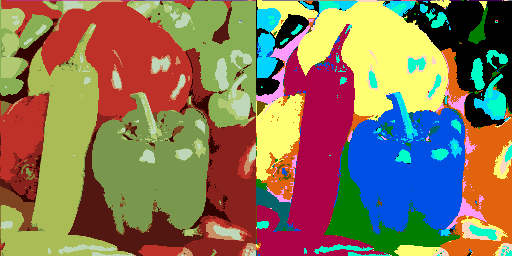

In [8]:
img_up = [segment_mean(seg, idx) for idx in labels_map(seg)]
lblcolors = distinguishable_colors(length(segment_mean(seg)))
img_arb = [lblcolors[idx] for idx in labels_map(seg)]
mosaic(img_up, img_arb; nrow=1)

As we can see, segmentation algorithm segmented the image into multiple regions and each region had similiar properties.

# Algorithms


### Seeded Region Growing
Seeded region growing segments an image with respect to some user-defined seeds. Each seed is a (position, label) tuple, where position is a CartesianIndex and label is a positive integer. By using the same label for multiple seeds, you manually "fuse" the segments together.

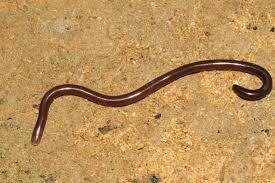

In [9]:
seeds = [(CartesianIndex(104, 48), 1), (CartesianIndex( 49, 40), 1),
                (CartesianIndex( 72,131), 1), (CartesianIndex(109,217), 1),
                (CartesianIndex( 28, 87), 2), (CartesianIndex( 64,201), 2),
                (CartesianIndex(104, 72), 2), (CartesianIndex( 86,138), 2)];
img = load("assets/worm.jpg")

seg = Segmented Image with:
  labels map: 183×275 Matrix{Int64}
  number of labels: 2


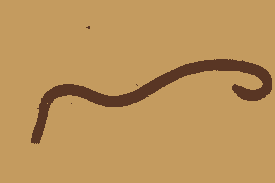

In [10]:
seg = seeded_region_growing(img, seeds)
@show seg
img_up = [segment_mean(seg, idx) for idx in labels_map(seg)]

## Unseeded Region Growing
This is the one we saw first; it's like Seeded Region Growing but it replaces the information about the seed points with a threshold, creating new seeds when no adjacent region is sufficiently similar. Let's see how it does on the same image:

seg = Segmented Image with:
  labels map: 183×275 Matrix{Int64}
  number of labels: 3


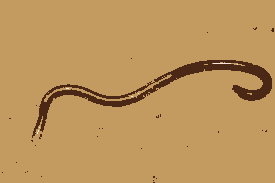

In [11]:
seg = unseeded_region_growing(img, 0.6)
@show seg
img_up = [segment_mean(seg, idx) for idx in labels_map(seg)]

### Felzenswalb's Region Merging Algorithm
This algorithm operates on a Region Adjacency Graph (RAG). Each pixel/region is a node in the graph and adjacent pixels/regions have edges between them with weight measuring the dissimilarity between pixels/regions. The algorithm repeatedly merges similar regions till we get the final segmentation. It efficiently computes oversegmented “superpixels” in an image.

seg = Segmented Image with:
  labels map: 183×275 Matrix{Int64}
  number of labels: 10


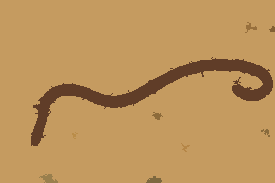

In [12]:
seg = felzenszwalb(img, #= merging threshold =# 30, #= minimum segment size =# 15)
@show seg
img_up = [segment_mean(seg, idx) for idx in labels_map(seg)]

### MeanShift Segmentation
MeanShift is a clustering technique. Its primary advantages are that it doesn't assume a prior on the shape of the cluster (e.g, gaussian for k-means) and we don't need to know the number of clusters beforehand. It requires that you specify a spatial radius `σ` and an "intensity radius" `ω`, and two pixels ${\bf x}_1 \rightarrow v_1$ and ${\bf x}_2 \rightarrow v_2$ are considered similar if

$$
\frac{({\bf x}_1 - {\bf x}_2)^2}{\sigma^2} + \frac{(v_1 - v_2)^2}{\omega^2} \le 1
$$

In principle, this is calculated for all pairs of pixels in the image; each point "flows" to the average ${\bf x}, v$ among similar pixels, and the process is iterated to approximate convergence. While we use tricks to prune the pairs that actually need to be considered, the calculation is fairly laborious, so this method does not scale very well to large images.

seg = Segmented Image with:
  labels map: 183×275 Matrix{Int64}
  number of labels: 5


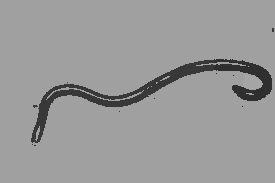

In [13]:
seg = meanshift(Gray.(img), #= spatial radius =# 16, #= intensity radius =# 50/255)
@show seg
img_up = [segment_mean(seg, idx) for idx in labels_map(seg)]

## Watershed Segmentation
The watershed algorithm treats an image as a topographic surface where bright pixels correspond to peaks and dark pixels correspond to valleys. The algorithm starts flooding from valleys (local minima) of this topographic surface and region boundaries are formed when water from different sources merge. If the image is noisy, this approach leads to oversegmetation.

When performing watershed, it's quite common to use the Euclidean Distance Transformation (EDT), which assigns to each pixel the distance to the nearest `true` pixel:

maximum(dist) = 21.93171219946131


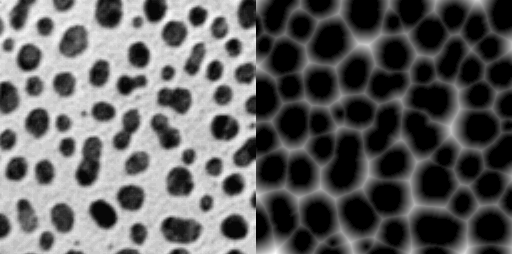

In [14]:
img = testimage("blobs")
bw = Gray.(img) .< 0.5;                             # `true` for the dark blobs
dist = distance_transform(feature_transform(bw));   # distance to nearest dark blob
@show maximum(dist)
mosaic(img, dist/maximum(dist); nrow=1)

`watershed` takes two inputs, the image itself (here we'll use the distance-transform `dist`) and a `markers` array, for which non-zero pixels specify the component index you want to assign to each "basin." A common choice is to generate `markers` using `label_components`:

In [15]:
markers = label_components(dist .< 1);
seg = watershed(dist, markers)

Segmented Image with:
  labels map: 254×256 Matrix{Int64}
  number of labels: 64

Now let's visualize the result:

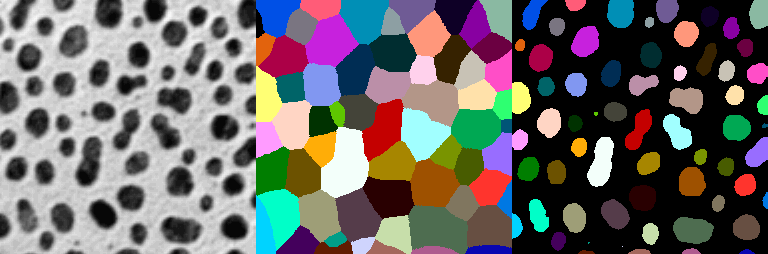

In [16]:
labels = labels_map(seg)
colored_labels = Images.IndirectArray(labels, distinguishable_colors(maximum(labels)))
masked_colored_labels = colored_labels .* bw
mosaic(img, colored_labels, masked_colored_labels; nrow=1)

In the middle image, you can see that watershed associated a "domain-of-influence" around each of the dark blobs, by assigning pixels to their nearest blob.

Check the documentation for more: https://juliaimages.org/latest